## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import interpolation
import math
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold





## Load Data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/submission.csv')

## EDA

### 기본 데이터 확인

In [3]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [4]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [5]:
pd.value_counts(train['letter'])

Z    91
K    90
O    90
H    89
L    89
G    87
Y    86
M    86
U    85
T    82
Q    82
R    81
F    80
X    79
N    77
D    76
S    76
C    74
V    73
A    72
B    71
W    69
J    67
P    66
E    66
I    64
Name: letter, dtype: int64

## 데이터 시각화

In [6]:
train.shape

(2048, 787)

In [7]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [8]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

### 원본 데이터 시각화

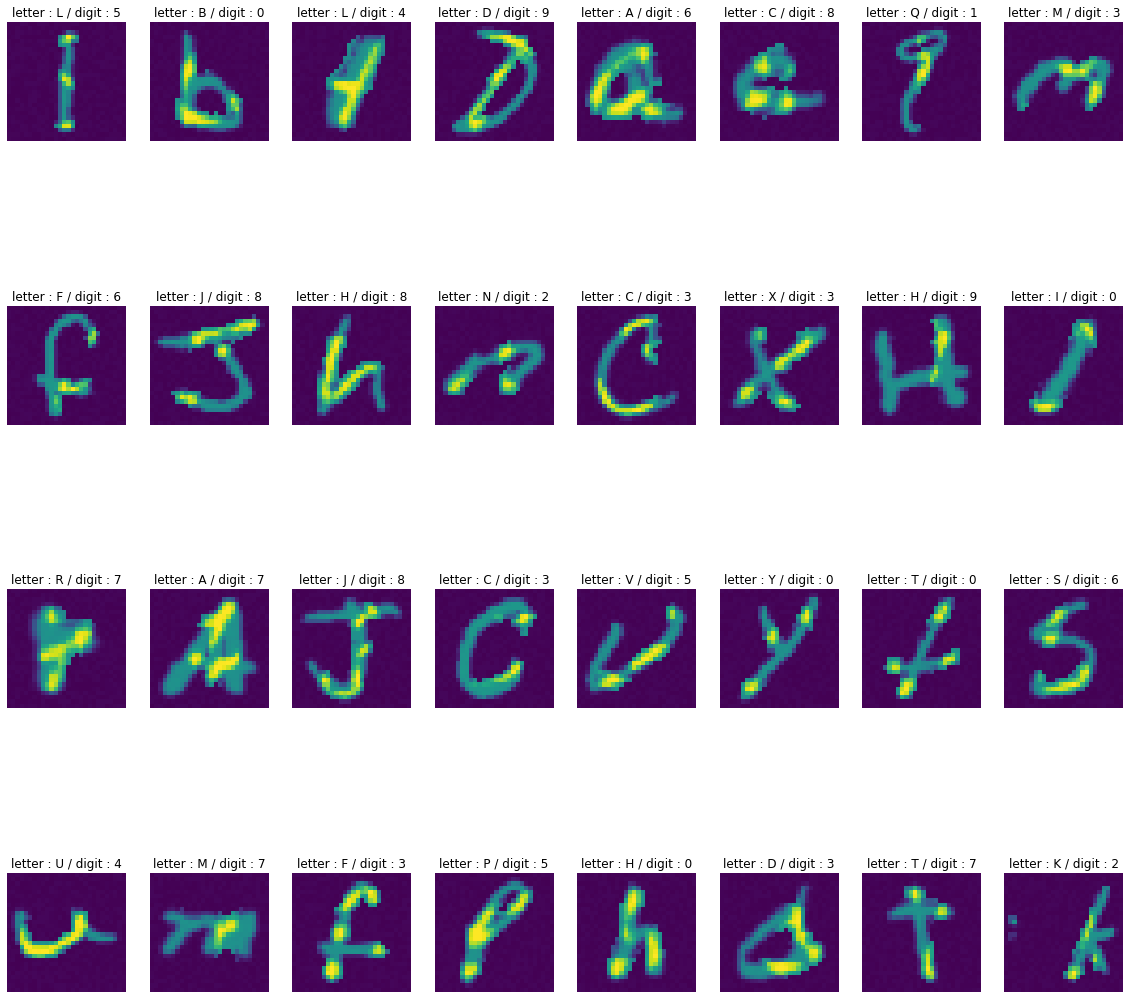

In [9]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

우리 눈에는 알파벳 모양만 보이고 숫자는 가려져서 잘 보이지 않습니다.  
원본 데이터는 숫자 위에 알파벳 마스크가 덮여져 있는 상태입니다. 

## utility function

뒤에서 사용할 함수를 미리 만들어 줍니다.

### 모델 학습 graph 

In [10]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [11]:
def digit_image(x):
    return np.where(x>=150, x, 0)

In [12]:
def digit_image255(x,thresold):
    return np.where(x>=thresold, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

### alphabet one-hot encoding (사용 안함)

In [13]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

### Deskew

이미지 형태를 일자로 맞춰줍니다.

In [14]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [15]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [17]:
def deskew_all(image_data):
    deskewed = []
    
    for i in range(len(image_data)):
        deskewed.append(deskew(image_data[i].reshape(28,28)))
    
    return np.array(deskewed)[:,:,:,np.newaxis]

## Feature Engineering

In [18]:
X_train = train.drop(['letter','id','digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)

X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)

X_trains = X_trains / 255.
TEST = TEST / 255.

print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [19]:
y_trains = train['digit']
y_trains = utils.to_categorical(y_trains, 10)
y_trains.shape

(2048, 10)

### 데이터 늘리기

In [19]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)

In [56]:
batch_size = 32
x_ = X_trains[:]
y_ = y_trains[:]
letter_ = alpha_one_hot(X_train_letter)
X_letter = alpha_one_hot(X_train_letter)
TEST_letter = alpha_one_hot(X_test_letter)

flow_image_digit = datagen.flow(x_, y_, batch_size=batch_size, seed=2020)
flow_image_letter = datagen.flow(x_, letter_, batch_size=batch_size, seed=2020)

In [20]:
test_datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='nearest'
)

In [21]:
x_test = X_trains[:]
y_test = y_trains[:]
X_trains_test = X_trains[:]
y_trains_test = y_trains[:]

In [22]:
batch_size=32

In [23]:
flow_image_digit_test = test_datagen.flow(x_test, y_test, batch_size=32, seed=2020)

In [24]:
for i in range(4):
    gen_imgs_test =  np.array([0]*784).reshape(1,28,28,1)
    gen_digits_test = np.array([0]*10).reshape(1,10)
    
    for _ in range(len(x_test)//batch_size):
        gen_img_test, gen_digit_test = flow_image_digit_test.next()
        
        gen_imgs_test = np.vstack((gen_imgs_test,gen_img_test))
        gen_digits_test = np.vstack((gen_digits_test,gen_digit_test))
        
    X_trains_test = np.vstack((X_trains_test, gen_imgs_test[1:]))
    y_trains_test = np.vstack((y_trains_test, gen_digits_test[1:]))


In [25]:
print(X_trains_test.shape)
print(y_trains_test.shape)

(10240, 28, 28, 1)
(10240, 10)


원본 데이터는 채널이 1개만 있습니다.  
우리는 이걸 3채널로 바꿀 것 입니다. 

### 숫자만 따로 분리하기

In [22]:
# X_train_digit = digit_image(X_trains)
# TEST_digit = digit_image(TEST)
# X_train_digit.shape

(10240, 28, 28, 1)

In [25]:
# X_train_digit = digit_image255(X_trains,0.55)
# TEST_digit = digit_image255(TEST, 0.55)
# X_train_digit.shape


(2048, 28, 28, 1)

In [26]:
X_train_digit_t = digit_image255(X_trains_test,0.55)
TEST_digit_t = digit_image255(TEST, 0.55)
X_train_digit_t.shape


(10240, 28, 28, 1)

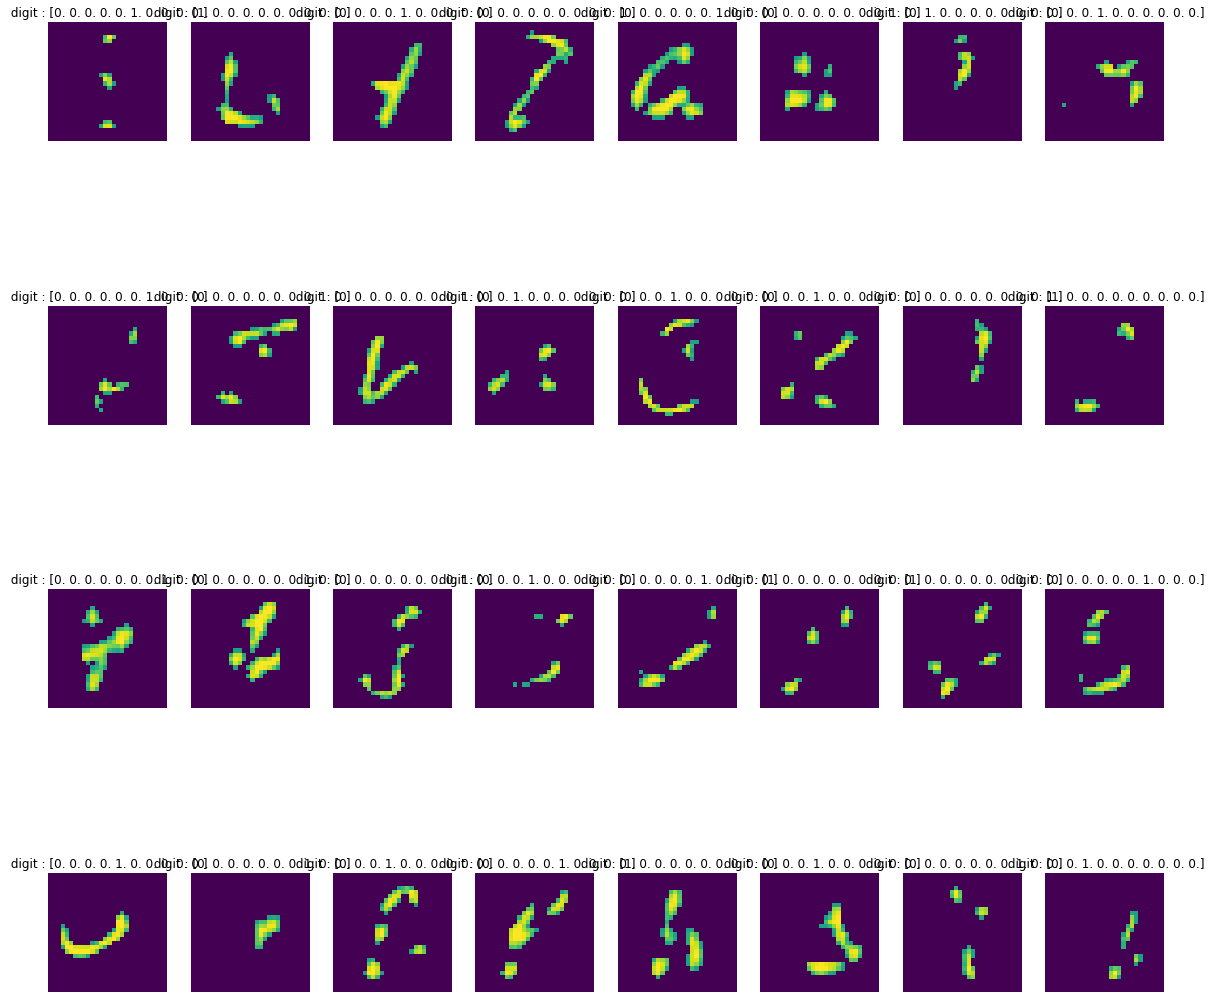

In [27]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(y_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_digit_t[idx]))
    title = ' digit : {}'.format(digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [28]:
X_train_digit_ = X_train_digit_t.reshape(-1,28,28)
X_train_digit_.shape

(10240, 28, 28)

In [29]:
digit_ref = np.zeros((10, 28, 28))
for (idx, digit) in enumerate(y_trains_test):
    digit = np.argmax(digit)
    digit_ref[digit] += X_train_digit_[idx]

digit_ref = digit_ref / np.max(digit_ref)

In [30]:
digit_ref.shape

(10, 28, 28)

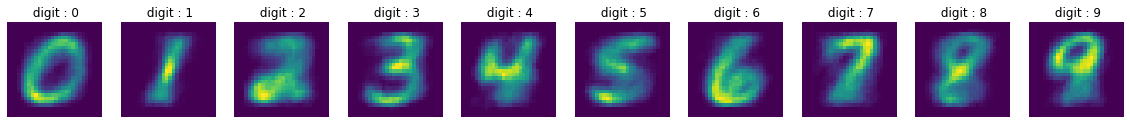

In [31]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(digit_ref[:]):
    plt.subplot(1,10,idx+1)
    plt.imshow(tf.squeeze(digit))
    title = ' digit : {}'.format(idx)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [32]:
digit_ref[digit_ref < 0.22] = 0
digit_ref[digit_ref >= 0.22] = 1
# digit_ref[digit_ref != 0] = 1

# digit_ref = digit_ref*1.8

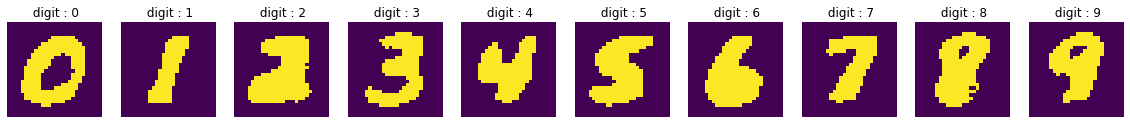

In [33]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(digit_ref[:]):
    plt.subplot(1,10,idx+1)
    plt.imshow(tf.squeeze(digit))
    title = ' digit : {}'.format(idx)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [34]:
digit_ref.shape

(10, 28, 28)

In [35]:
# digit_ref = deskew_all(digit_ref)

In [36]:
# digit_ref[digit_ref < 0.8] = 0
# digit_ref[digit_ref > 1] = 1

In [37]:
# plt.figure(figsize=(20,20))
# for idx, digit in enumerate(digit_ref[:]):
#     plt.subplot(1,10,idx+1)
#     plt.imshow(tf.squeeze(digit))
#     title = ' digit : {}'.format(idx)
#     plt.title(title, fontdict={'color':'black'})
#     plt.axis('off')

In [38]:
origin_digit = pd.DataFrame(digit_ref.reshape(10,-1))
origin_digit['digit'] = range(0,10)



In [39]:
origin_digit

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [40]:
rcs = np.argmax(y_trains_test, axis=1)

In [41]:
rcs

array([5, 0, 4, ..., 8, 9, 5])

In [42]:
y_trains_tests = pd.DataFrame({'digit' : rcs})

In [43]:
y_trains_tests

,digit
0,5
1,0
2,4
3,9
4,6
...,...
10235,6
10236,2
10237,8
10238,9


In [40]:
#original digit 구성
y_origin = train['digit'].to_frame(name='digit').reset_index()

In [41]:
y_origin

,index,digit
0,0,5
1,1,0
2,2,4
3,3,9
4,4,6
...,...,...
2043,2043,6
2044,2044,1
2045,2045,9
2046,2046,0


In [42]:
y_origin['index'] = y_origin['index'].astype(int)
origin_digit = pd.merge(y_origin, origin_digit, on = ['digit'], how = 'left')

In [47]:
origin_digit = pd.merge(y_trains_tests, origin_digit, on = ['digit'], how = 'left')

In [43]:
origin_digit

,index,digit,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2043,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,2044,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2045,2045,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2046,2046,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
y_origin_digit = origin_digit['digit']
y_origin_digit = utils.to_categorical(y_origin_digit, 10)

origin_digit = origin_digit.drop(['index','digit'],axis=1)

In [45]:
origin_digit

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
origin_digit = origin_digit.values.reshape(-1,28,28,1)

In [47]:
y_origin_digit

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

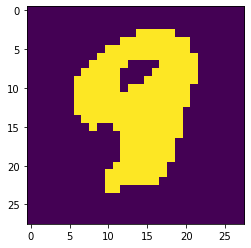

In [52]:
plt.imshow(tf.squeeze(origin_digit[3]))

In [ ]:
x_test = X_trains[:]
y_test = y_trains[:]

y_trains_test = y_trains[:]
flow_image_digit_test = test_datagen.flow(x_test, y_test, batch_size=32, seed=2020)
for i in range(4):
    gen_imgs_test =  np.array([0]*784).reshape(1,28,28,1)
    gen_digits_test = np.array([0]*10).reshape(1,10)
    
    for _ in range(len(x_test)//batch_size):
        gen_img_test, gen_digit_test = flow_image_digit_test.next()
        
        gen_imgs_test = np.vstack((gen_imgs_test,gen_img_test))
        gen_digits_test = np.vstack((gen_digits_test,gen_digit_test))
        
    X_trains_test = np.vstack((X_trains_test, gen_imgs_test[1:]))
    y_trains_test = np.vstack((y_trains_test, gen_digits_test[1:]))


In [48]:
x_test_autos = origin_digit[:]
y_test_autos = y_origin_digit[:]
X_trains_autos = origin_digit[:]
y_trains_autos = y_origin_digit[:]
X_trains_test = X_trains[:]


batch_size=32
datagen_ = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    fill_mode='nearest'
)

flow_image_digit_test_ = datagen_.flow(x_test_autos, y_test_autos, batch_size=32, seed=2020)
for i in range(4):
    gen_imgs_test_ =  np.array([0]*784).reshape(1,28,28,1)
    gen_digits_test_ = np.array([0]*10).reshape(1,10)
    
    for _ in range(len(x_test_autos)//batch_size):
        gen_img_test_, gen_digit_test_ = flow_image_digit_test_.next()
        
        gen_imgs_test_ = np.vstack((gen_imgs_test_,gen_img_test_))
        gen_digits_test_ = np.vstack((gen_digits_test_,gen_digit_test_))
        
    X_trains_autos = np.vstack((X_trains_autos, gen_imgs_test_[1:]))
    y_trains_autos = np.vstack((y_trains_autos, gen_digits_test_[1:]))


In [49]:
# Encoder 
inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

In [50]:
# Decoder

x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

In [62]:
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248

In [63]:
# train_digit_train, train_digit_valid, y_train2, y_valid2 = train_test_split(X_train_digit_t, y_trains_test, test_size=0.2, shuffle = False)

In [64]:

train_digit_train, train_digit_valid, y_train2, y_valid2 = train_test_split(X_trains_test, y_trains_test, test_size=0.2, shuffle = False)

In [65]:
noise = 0
train_noise = train_digit_train + noise * np.random.normal(0, 1, size=train_digit_train.shape)
test_noise = train_digit_valid + noise * np.random.normal(0, 1, size=train_digit_valid.shape)

train_noise = np.clip(train_noise, 0, 1)
test_noise = np.clip(test_noise, 0, 1)

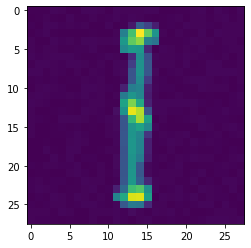

In [66]:
plt.imshow(tf.squeeze(train_noise[0]))

In [67]:
origin_digit_train, origin_digit_valid, y_train3, y_valid3 = train_test_split(origin_digit, y_origin_digit, test_size=0.2, shuffle = False)


In [68]:
origin_digit_train, origin_digit_valid, y_train3, y_valid3 = train_test_split(X_trains_autos, y_trains_autos, test_size=0.2, shuffle = False, random_state=2020)

In [69]:
# epochs = 80
epochs = 200
batch_size = 32 #으로 바꿔서도 해보기

history = autoencoder.fit(train_noise,origin_digit_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_noise, origin_digit_valid)
               )

Epoch 1/200
256/256 [==============================] - 1s 3ms/step - loss: 0.4558 - val_loss: 0.4994
Epoch 2/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4560 - val_loss: 0.5051
Epoch 3/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4553 - val_loss: 0.5051
Epoch 4/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4554 - val_loss: 0.4975
Epoch 5/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4550 - val_loss: 0.5094
Epoch 6/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4551 - val_loss: 0.5031
Epoch 7/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4548 - val_loss: 0.5083
Epoch 8/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4553 - val_loss: 0.5050
Epoch 9/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4552 - val_loss: 0.5013
Epoch 10/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4552 - val_lo

Epoch 161/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4505 - val_loss: 0.5019
Epoch 162/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4504 - val_loss: 0.5160
Epoch 163/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4507 - val_loss: 0.5049
Epoch 164/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.5008
Epoch 165/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4499 - val_loss: 0.5124
Epoch 166/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4502 - val_loss: 0.5026
Epoch 167/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4502 - val_loss: 0.5054
Epoch 168/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4507 - val_loss: 0.5095
Epoch 169/200
256/256 [==============================] - 1s 2ms/step - loss: 0.4508 - val_loss: 0.5088
Epoch 170/200
256/256 [==============================] - 1s 2ms/step - lo

In [60]:
# Select few random tes images
num_imgs = 32
#rand = np.random.randint(, 100)

# test_images = train_noise[0:num_imgs]*255 # slicing
test_images = train_noise[0:num_imgs]
test_desoided = autoencoder.predict(test_images) # predict

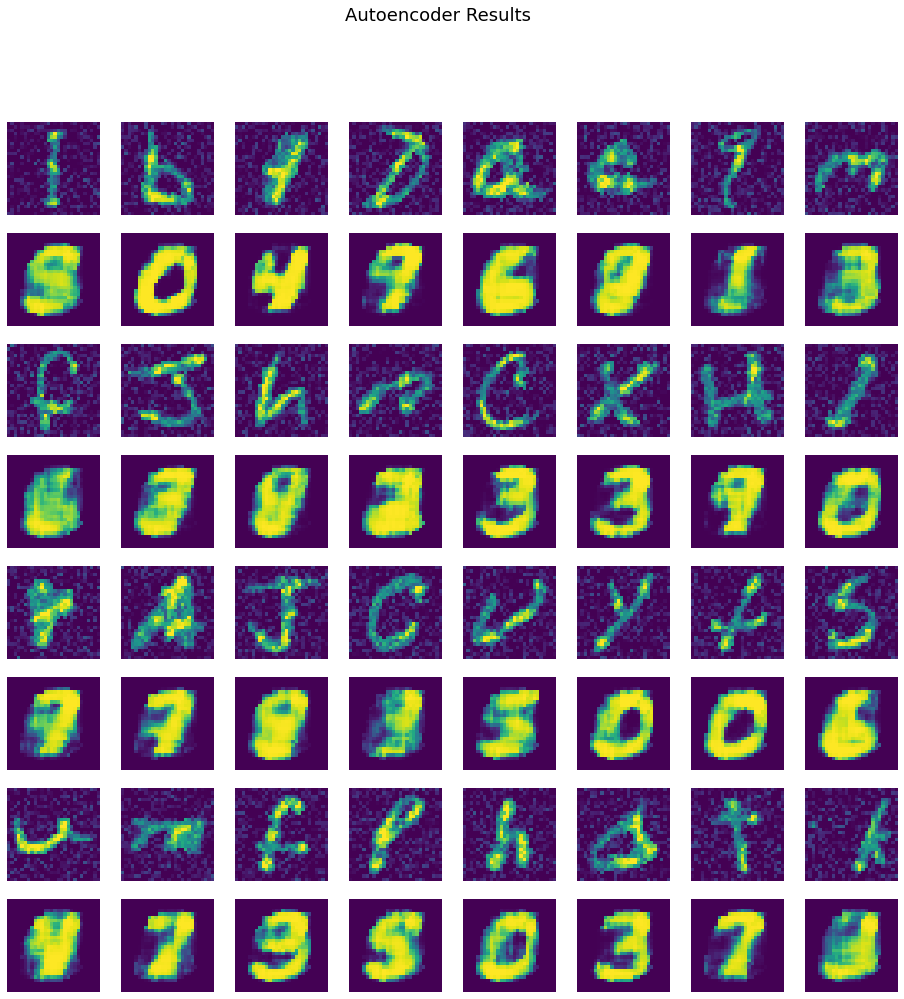

[5 0 4 9 6 8 1 3]
[6 8 8 2 3 3 9 0]
[7 7 8 3 5 0 0 6]
[4 7 3 5 0 3 7 2]


In [62]:
# Visualize test images with their denoised images  0.1/ 400 / 20480

rows = 4 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_images[i*cols + j].reshape([28,28])) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_desoided[i*cols + j].reshape([28,28])) 
        plt.axis("off")
        
f.suptitle("Autoencoder Results",fontsize=18)
plt.savefig("test_results.png")

plt.show()

d = np.argmax(y_train2[0:32], axis=1)
print(d[:8])
print(d[8:16])
print(d[16:24])
print(d[24:])



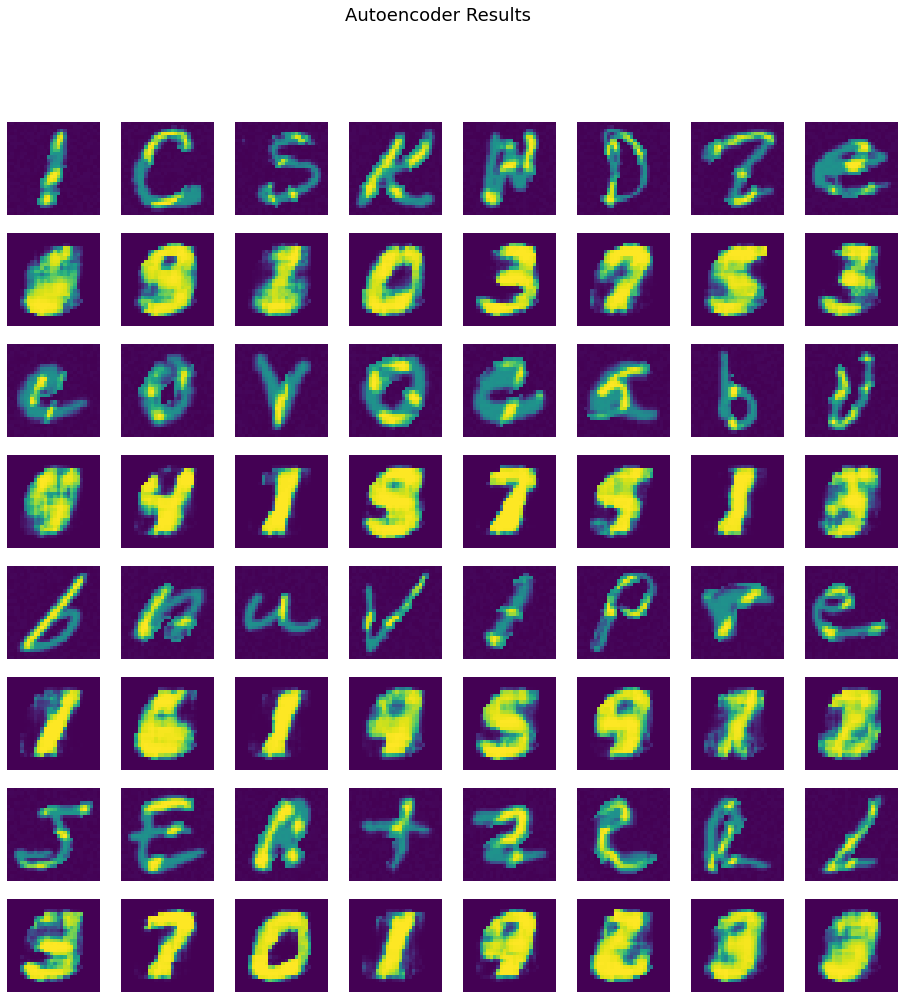

[5 0 4 9 6 8 1 3]
[6 8 8 2 3 3 9 0]
[7 7 8 3 5 0 0 6]
[4 7 3 5 0 3 7 2]


In [1148]:
### TEST 확인
test_images = TEST[0:num_imgs]
test_desoided = autoencoder.predict(test_images)
# Visualize test images with their denoised images  0.09/ 200

rows = 4 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_images[i*cols + j].reshape([28,28])) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_desoided[i*cols + j].reshape([28,28])) 
        plt.axis("off")
        
f.suptitle("Autoencoder Results",fontsize=18)
plt.savefig("test_results.png")

plt.show()

d = np.argmax(y_train2[0:32], axis=1)
print(d[:8])
print(d[8:16])
print(d[16:24])
print(d[24:])



In [1072]:
test_desoidedss = deskew_all(test_desoided)

### 오토인코더로 숫자 생성

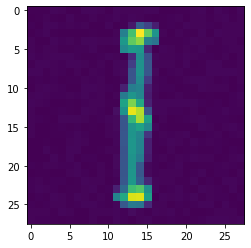

In [63]:
plt.imshow(tf.squeeze(X_trains[0]))

In [74]:
train_auto = autoencoder.predict(X_trains)
test_auto = autoencoder.predict(TEST)

In [66]:
train_auto2 = autoencoder.predict(X_trains_test)
test_auto2 = autoencoder.predict(TEST)

In [67]:
train_auto2.shape

(10240, 28, 28, 1)

In [68]:
test_auto2.shape

(20480, 28, 28, 1)

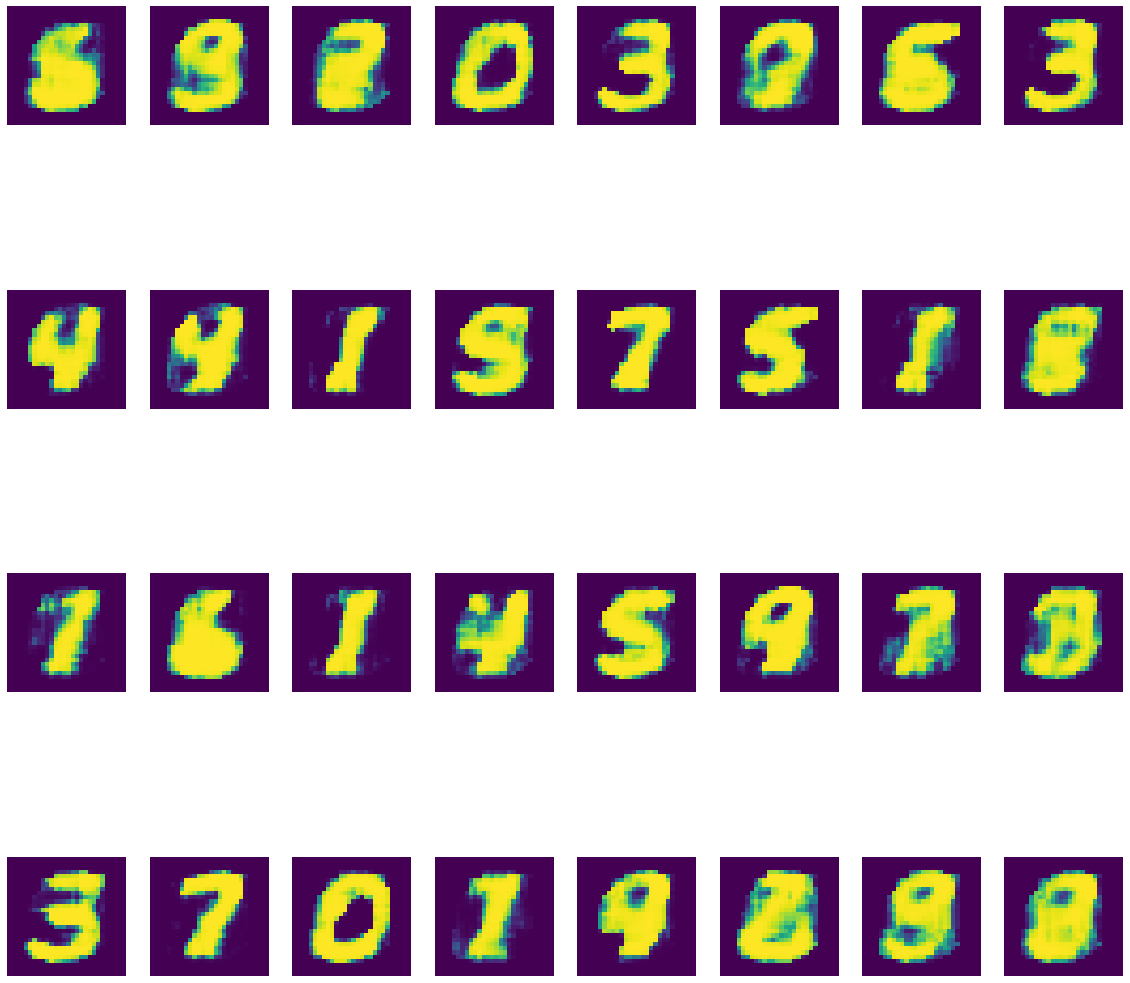

In [72]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(test_auto2[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(test_auto2[idx]))
#     title = ' digit : {}'.format(digit)
#     plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [73]:
with open('../data/noise0_data.npy', 'wb') as f:
    np.save(f, train_auto2)
    np.save(f, y_trains_test)
    np.save(f, test_auto2)


In [75]:
train_auto.shape

(2048, 28, 28, 1)

In [76]:
test_auto.shape

(20480, 28, 28, 1)

### 오토인코더 데이터 늘리기 

In [77]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)

In [78]:
batch_size = 32
x_ = train_auto[:]
y_ = y_trains[:]
y_auto = y_trains[:]

flow_image_digit = datagen.flow(x_, y_, batch_size=batch_size, seed=2020)

In [79]:
for i in range(4):
#     gen_imgs =  np.array([0]*784*2048).reshape(2048,28,28,1)
    gen_imgs =  np.array([0]*784).reshape(1,28,28,1)
    gen_digits = np.array([0]*10).reshape(1,10)
    
    for _ in range(len(x_)//batch_size):
        gen_img, gen_digit = flow_image_digit.next()
        
        gen_imgs = np.vstack((gen_imgs,gen_img))
        gen_digits = np.vstack((gen_digits,gen_digit))
        
    train_auto = np.vstack((train_auto, gen_imgs[1:]))
    y_auto = np.vstack((y_auto, gen_digits[1:]))

In [80]:
print(train_auto.shape)
print(y_auto.shape)

(10240, 28, 28, 1)
(10240, 10)


In [81]:
with open('../data/noise0_gen_data.npy', 'wb') as f:
    np.save(f, train_auto)
    np.save(f, y_auto)
    np.save(f, test_auto)


### deskew auto

In [82]:
train_auto = deskew_all(train_auto)
test_auto = deskew_all(test_auto)

In [83]:
with open('../data/noise0_deskew_data.npy', 'wb') as f:
    np.save(f, train_auto)
    np.save(f, y_auto)
    np.save(f, test_auto)


In [69]:
with open('../data/auto10000_data.npy', 'wb') as f:
    np.save(f, train_auto)
    np.save(f, y_auto)
    np.save(f, test_auto)


### 알파벳만 따로 분리하기

In [66]:
X_train_alpha = X_trains_test - X_train_digit_t/2
TEST_alpha = TEST - TEST_digit_t/2
X_train_alpha.shape

(10240, 28, 28, 1)

In [67]:
TEST.shape

(20480, 28, 28, 1)

In [68]:
X_trains = np.concatenate((X_trains_test, train_auto2, X_train_alpha),axis=-1)
TEST = np.concatenate((TEST, test_auto2, TEST_alpha),axis=-1)


print(X_trains.shape)
print(TEST.shape)

print(y_trains_test.shape)

(10240, 28, 28, 3)
(20480, 28, 28, 3)
(10240, 10)


In [69]:
with open('../data/auto3_new_data.npy', 'wb') as f:
    np.save(f, X_trains)
    np.save(f, y_trains_test)
    np.save(f, TEST)


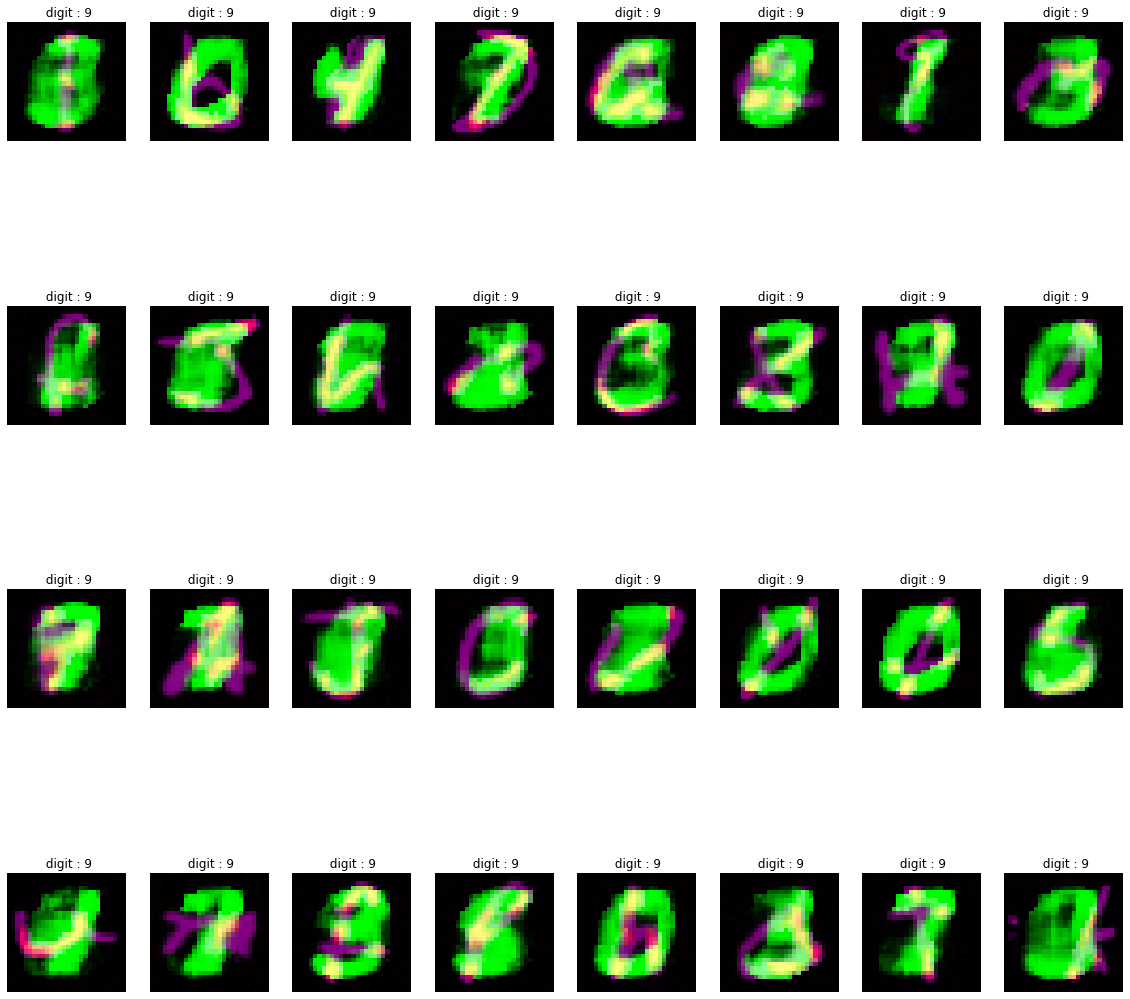

In [70]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_trains[idx]))
#     title = ' digit : {}'.format(letter/abs
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

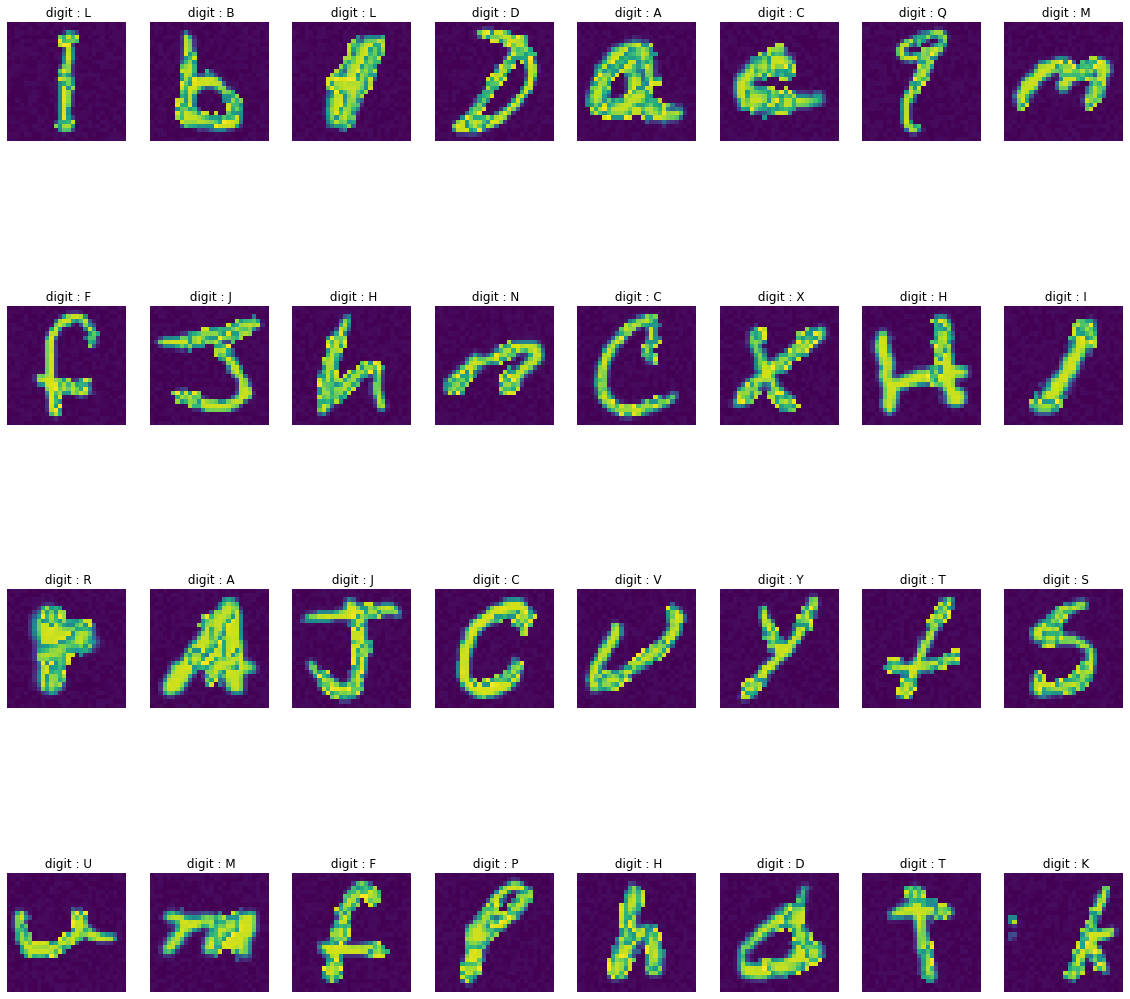

In [76]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_train_letter[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_alpha[idx]))
    title = ' digit : {}'.format(letter)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [24]:
X_train_alpha = X_trains - X_train_digit/2
TEST_alpha = TEST - TEST_digit/2
X_train_alpha.shape

(10240, 28, 28, 1)

### 분리한 알파벳 일자로 펴주기

In [26]:
# X_train_alpha = deskew_all(X_train_alpha)
# TEST_alpha = deskew_all(TEST_alpha)
# X_train_alpha.shape

In [27]:
# plt.figure(figsize=(20,20))
# for idx, letter in enumerate(X_train_letter[:32]):
#     plt.subplot(4,8,idx+1)
#     plt.imshow(tf.squeeze(X_train_alpha[idx]))
#     title = ' digit : {}'.format(letter)
#     plt.title(title, fontdict={'color':'black'})
#     plt.axis('off')

### 3채널 만들기 (원본, 숫자, 글자)

In [28]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
TEST = np.concatenate((TEST, TEST_digit, TEST_alpha),axis=-1)

X_trains = X_trains.astype('float32')
X_letter = X_letter.astype('float32')
TEST_letter = TEST_letter.astype('float32')
TEST = TEST.astype('float32')

X_trains = X_trains/255.
TEST = TEST/255.

print(X_trains.shape)
print(TEST.shape)
print(y_trains.shape)
print(X_letter.shape)
print(TEST_letter.shape)

(10240, 28, 28, 3)
(20480, 28, 28, 3)
(10240, 10)
(10240, 26)
(20480, 26)


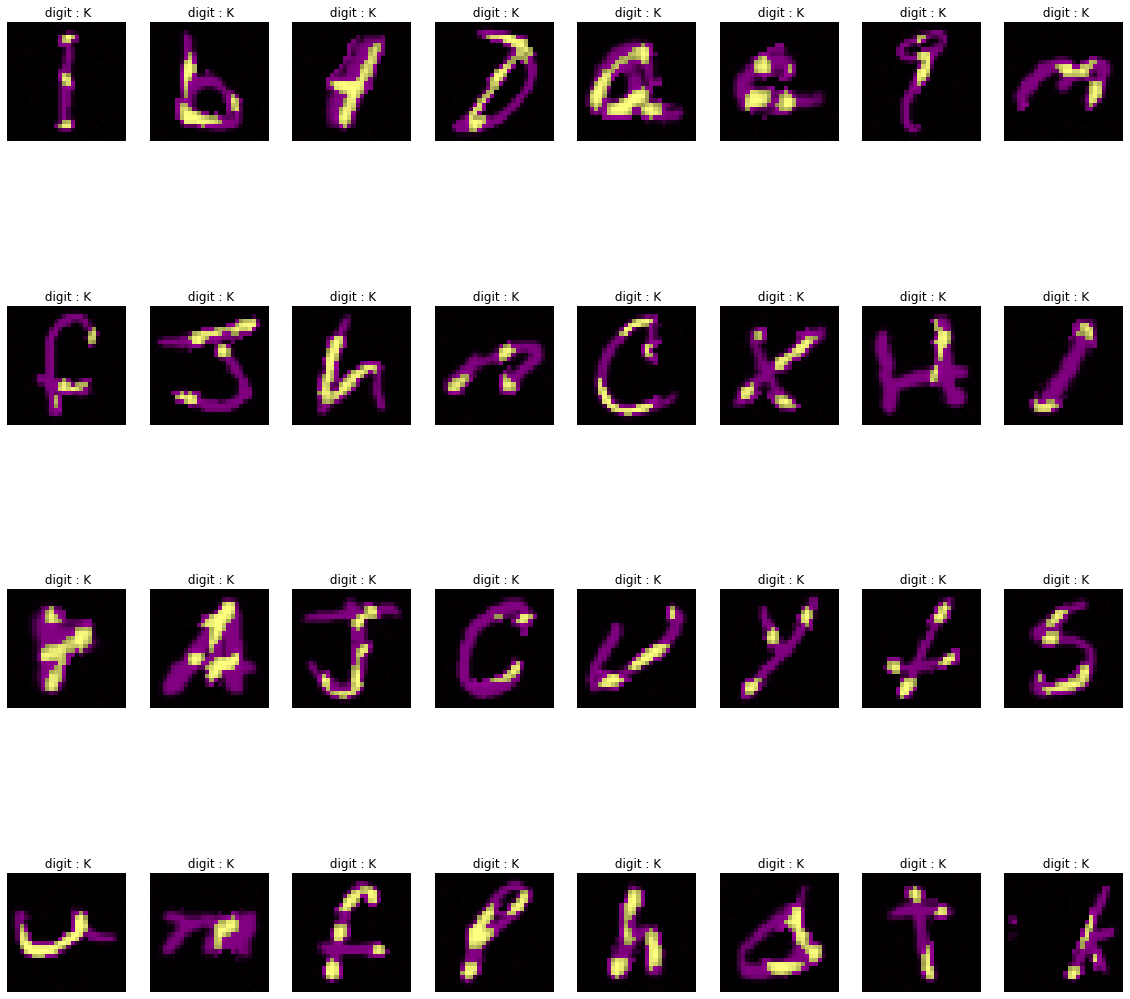

In [29]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_trains[idx]))
#     title = ' digit : {}'.format(letter/abs
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

In [30]:
with open('../data/no_deskew_data.npy', 'wb') as f:
    np.save(f, X_trains)
    np.save(f, X_letter)
    np.save(f, y_trains)
    np.save(f, TEST)
    np.save(f, TEST_letter)